In [1]:
import numpy as np, numpy.random as npr, torch.nn as nn, timeit, torch, pystan as ps, arviz
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import plot, show, legend
from tqdm import trange
from scipy.stats import gaussian_kde
from samplers import *

#### Generate data:

In [2]:
n_in = 1
n_out = 2

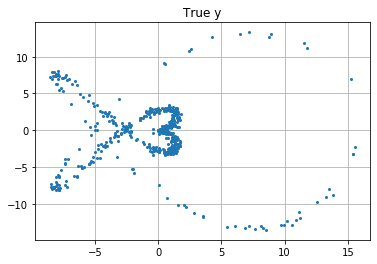

In [3]:
error_sigma2 = 0.05
dd = np.load("model1.npy")
X, Y = dd.item()['X'], dd.item()['Y']
X.requires_grad = True
plt.plot(list(Y[:,0]), list(Y[:,1]), 'o', markersize=2)
plt.grid(True)
plt.title("True y")
criterion = nn.MSELoss()
Nobs = np.shape(X)[0]

### Testing GP prior for latent $X$:

#### Compile Stan function:

In [4]:
sm = ps.StanModel(file="nn_refpointsrefNN.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_32c4881df1a454afbdf5d861395de0e0 NOW.


#### Run optimisation for NN:

In [5]:
n_h1 = 50
model = nn.Sequential(nn.Linear(n_in, n_h1), nn.Tanh(), nn.Linear(n_h1, n_out))
def init_normal(m) :
    if type(m) == nn.Linear :
        nn.init.normal_(m.weight)

In [6]:
model.apply(init_normal)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=True)
n_iter = 50_000
start = time()
for epoch in range(n_iter):
    y_pred = model(X)
    loss = criterion(y_pred, Y)
    if (epoch+1)%(n_iter/10) == 0 :
        print("Epoch: %d; loss: %.3f; time: %.1f mins" % (epoch+1, loss.item(), (time()-start)/60))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 5000; loss: 1.103; time: 0.2 mins
Epoch: 10000; loss: 0.625; time: 0.3 mins
Epoch: 15000; loss: 0.373; time: 0.5 mins
Epoch: 20000; loss: 0.250; time: 0.7 mins
Epoch: 25000; loss: 0.185; time: 0.9 mins
Epoch: 30000; loss: 0.151; time: 1.0 mins
Epoch: 35000; loss: 0.130; time: 1.1 mins
Epoch: 40000; loss: 0.116; time: 1.3 mins
Epoch: 45000; loss: 0.107; time: 1.5 mins
Epoch: 50000; loss: 0.099; time: 1.6 mins


In [7]:
pm = []
for name, param in model.named_parameters():
    if param.requires_grad:
        pm.append(param.data.numpy())
weights_1, bias_1, weights_2, bias_2 = pm

In [8]:
n_ref_w1, n_ref_b1, n_ref_w2 = 10, 10, 10;

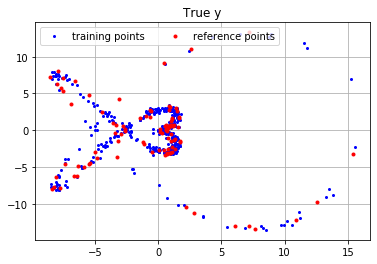

In [9]:
n_ref = 100
ref = npr.choice(Nobs,n_ref,replace=False)
train = np.setdiff1d(np.arange(Nobs), ref)
y_ref = Y[ref]
X_ref = X[ref].detach().numpy()
plt.plot(list(Y[train,0]), list(Y[train,1]), 'bo', markersize=2, label="training points")
plt.plot(list(Y[ref,0]), list(Y[ref,1]), 'ro', markersize=3, label="reference points")
plt.grid(True)
plt.title("True y")
plt.legend(ncol=2)

In [11]:
data = dict(Nobs=Nobs, in_dim=n_in, out_dim=n_out, hidden_dim_1=n_h1,
            n_ref=n_ref, n_ref_w1=n_ref_w1, n_ref_b1=n_ref_b1, n_ref_w2=n_ref_w2,
            weights_1_ref=weights_1[:n_ref_w1].transpose(),
            bias_1_ref=bias_1[:n_ref_b1],
            weights_2_ref=weights_2[:,:n_ref_w2].transpose(),
            y=Y[train].detach().numpy(), y_ref=y_ref, X_ref=X_ref)

#### Run sampling algorithm:

In [12]:
control = dict(adapt_delta=0.9, max_treedepth=12)
start = time()
fit = sm.sampling(data=data, thin=1, n_jobs=1, chains=1, init="random", iter=1_000, control=control)
print(round((time()-start)/60,2), "minutes to run")
print(fit);

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


247.92 minutes to run
Inference for Stan model: anon_model_32c4881df1a454afbdf5d861395de0e0.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
X[1,1]             2.2  1.3e-3 5.6e-3   2.19    2.2    2.2   2.21   2.21     19    1.0
X[2,1]           -0.17    0.02   0.14  -0.48  -0.26  -0.17  -0.07    0.1     61   1.06
X[3,1]            0.91  3.8e-3   0.03   0.86   0.89   0.91   0.93   0.99     83   1.05
X[4,1]           -1.56  1.6e-310.0e-3  -1.58  -1.57  -1.56  -1.55  -1.54     37   1.01
X[5,1]           -0.29    0.02   0.13  -0.48  -0.39  -0.31  -0.22 5.3e-3     38    1.0
X[6,1]            0.38    0.02   0.09   0.15   0.32    0.4   0.45   0.51     28    1.0
X[7,1]            0.56  4.3e-3   0.02   0.51   0.55   0.56   0.57   0.59     22   1.04
X[8,1]             0.1    0.02   0.15  -0.19  -0.01    0.1   0.19   0.39     52    1.0
X[9,1]   

In [13]:
trace = fit.extract()
(fit.get_sampler_params())

[OrderedDict([('accept_stat__',
               array([1.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
                      9.26778216e-001, 9.98572120e-001, 9.99962232e-001, 9.99939977e-001,
                      9.99076597e-001, 7.52791634e-001, 9.84818016e-001, 9.97007686e-001,
                      7.83404475e-001, 9.68094062e-001, 8.26189175e-001, 4.86209873e-001,
                      9.97744959e-001, 9.40607218e-001, 9.41151975e-001, 6.78760916e-002,
                      9.96525794e-001, 9.99877176e-001, 9.95777843e-001, 9.98522527e-001,
                      9.98124488e-001, 8.42456563e-001, 7.05197005e-001, 8.69396926e-001,
                      8.81149258e-001, 9.89509051e-001, 9.14766980e-001, 9.24302157e-001,
                      9.51465540e-001, 7.21025573e-001, 8.90834385e-001, 7.77165440e-001,
                      9.98781579e-001, 9.57572606e-001, 1.97643462e-001, 9.87399182e-001,
                      9.99873080e-001, 9.83954203e-001, 9.86015381e-

### Plot IACTs:

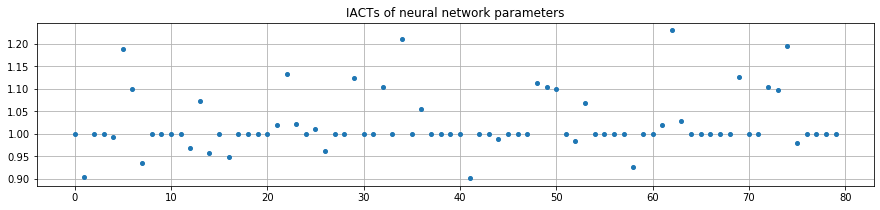

In [15]:
iact_nn = [gewer_estimate_IAT(trace['weights_1'][:,0,j]) 
          for j in np.arange(10,np.shape(trace['weights_1'])[-1])] + \
         [gewer_estimate_IAT(trace['bias_1'][:,j]) 
         for j in np.arange(10,np.shape(trace['bias_1'])[-1])] + \
[gewer_estimate_IAT(trace['weights_2'][:,i,j]) 
         for i in range(np.shape(trace['weights_2'])[-2]) 
         for j in np.arange(10,np.shape(trace['weights_2'])[-1])] + \
[gewer_estimate_IAT(trace['bias_2'][:,j]) 
         for j in np.arange(10,np.shape(trace['bias_2'])[-1])]
plt.figure(figsize=(15,3))
plt.plot(iact_nn, 'o', markersize=4)
plt.grid(True)
plt.title("IACTs of neural network parameters");

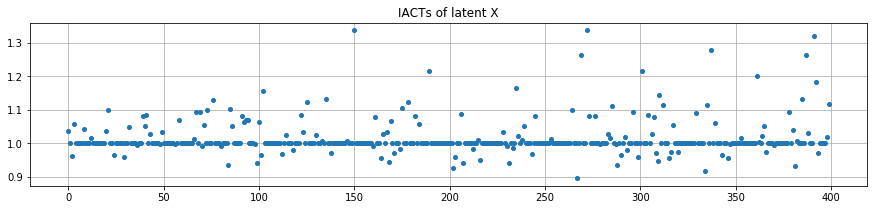

In [16]:
iact_x = [gewer_estimate_IAT(trace['X'][:,i,0]) for i in range(np.shape(trace['X'])[-2])]
plt.figure(figsize=(15,3))
plt.plot(iact_x, 'o', markersize=4)
plt.grid(True)
plt.title("IACTs of latent X");

#### Plot final:

In [48]:
n_HMC = np.shape(trace['X'])[0]
y_predicted = np.zeros((n_HMC, Nobs-100, n_out))
for i in range(Nobs-100) :
    y_predicted[i] = np.matmul(np.tanh(trace['X'][i]*trace['weights_1'][i] +
                                       trace['bias_1'][i]),trace['weights_2'][i]) + \
    trace['bias_2'][i] 

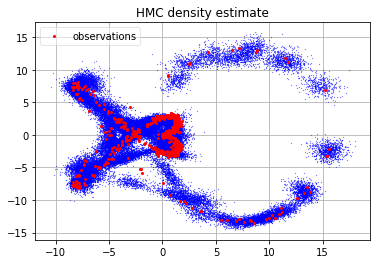

In [52]:
fig = plt.figure()
for i in range(Nobs) :
    plt.plot(y_predicted[i,:,0],y_predicted[i,:,1], 'bo', markersize=0.2)
plt.plot(list(Y[:,0]), list(Y[:,1]), 'ro', markersize=2, label="observations")
plt.grid(True)
plt.title("HMC density estimate");
plt.legend(ncol=2, loc='upper left', fancybox=True, framealpha=0.5)
fig.savefig('density_refpointsrefNN.png', dpi=1000, bbox_inches = 'tight')

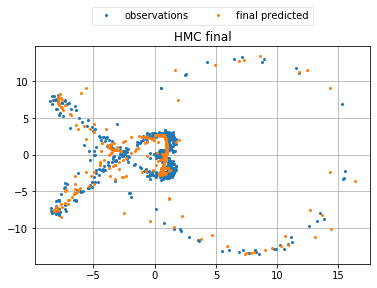

In [46]:
fig = plt.figure()
trace = fit.extract()
y_pred = np.matmul(np.tanh(trace['X'][-1]*trace['weights_1'][-1] \
                           + trace['bias_1'][-1]),trace['weights_2'][-1]) \
         + trace['bias_2'][-1] 

plt.plot(list(Y[:,0]), list(Y[:,1]), 'ro', markersize=2, label="observations")
plt.plot(y_pred[:,0],y_pred[:,1], 'go', markersize=2, label="final predicted")
plt.grid(True)
plt.legend(ncol=2, loc=[0.17,1.1], fancybox=True, framealpha=0.5)
plt.title("HMC final");
fig.savefig('final_refpointsrefNN.png', dpi=1000, bbox_inches = 'tight')

### Predictive distribution:

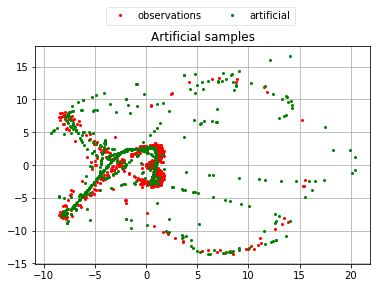

In [53]:
fig = plt.figure()
Ntest = 1_000
X_test = npr.randn(Ntest, n_in)
y_test = np.matmul(np.tanh(X_test*trace['weights_1'][-1] \
                           + trace['bias_1'][-1]),trace['weights_2'][-1]) \
         + trace['bias_2'][-1] 
plt.plot(list(Y[:,0]), list(Y[:,1]), 'ro', markersize=2, label="observations")
plt.plot(y_test[:,0],y_test[:,1], 'go', markersize=2, label="artificial")
plt.title("Artificial samples");
plt.grid(True)
plt.legend(ncol=2, loc=[0.21,1.1], fancybox=True, framealpha=0.5);
fig.savefig('predicted_refpointsrefNN.png', dpi=1000, bbox_inches = 'tight')